In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

import keras as keras
from keras.layers import Dropout


import h5py

from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler

plt.rcParams['figure.figsize'] = (12,6)

In [4]:
df = pd.read_csv('penguins_simple.csv', sep=';')

In [5]:
X = df.iloc[:, 1:5] / 100
y = pd.get_dummies(df['Species'])

X.isnull().sum()

Culmen Length (mm)     0
Culmen Depth (mm)      0
Flipper Length (mm)    0
Body Mass (g)          0
dtype: int64

In [6]:
X.columns

Index(['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)',
       'Body Mass (g)'],
      dtype='object')

In [7]:
X.shape

(333, 4)

In [8]:
trans = ColumnTransformer([
    ('categorial_imputer', MinMaxScaler(), ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)',
       'Body Mass (g)']),
    ('numeric_imputer', StandardScaler(), ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)',
       'Body Mass (g)'])
])

trans.fit(X)                    
X_t = trans.transform(X) 
X_t

array([[ 0.25454545,  0.66666667,  0.15254237, ...,  0.7807321 ,
        -1.42675157, -0.56847478],
       [ 0.26909091,  0.51190476,  0.23728814, ...,  0.11958397,
        -1.06947358, -0.50628618],
       [ 0.29818182,  0.58333333,  0.38983051, ...,  0.42472926,
        -0.42637319, -1.1903608 ],
       ...,
       [ 0.66545455,  0.30952381,  0.84745763, ..., -0.74499437,
         1.50292796,  1.91906927],
       [ 0.47636364,  0.20238095,  0.6779661 , ..., -1.20271231,
         0.78837197,  1.23499466],
       [ 0.64727273,  0.35714286,  0.69491525, ..., -0.54156417,
         0.85982757,  1.48374906]])

In [9]:
# MNIST: (60000, 28, 28) reshape to (60000, 784)

In [10]:
X_t.shape, y.shape

((333, 8), (333, 3))

In [23]:
K.clear_session() # reset your model parameters and everything

#### Batch normalization, 

or batchnorm for short, is proposed as a technique to help coordinate the update of multiple layers in the model.

How to Standardize Layer Inputs

Batch normalization can be implemented during training by calculating the mean and standard deviation of each input variable to a layer per mini-batch and using these statistics to perform the standardization.

Alternately, a running average of mean and standard deviation can be maintained across mini-batches, but may result in unstable training.

In [12]:
# TODO: try adding a BatchNormalization layer (regularization + speedup)

Not suggested both Dropout and BatchNormalization to be used together.
The reason is that the statistics used to normalize the activations of the prior layer may become noisy given the random dropping
out of nodes during the dropout procedure.


#Personal assumption here:
When commenting the under parameters, i had much better results, the model performed significantly bette.
It can be that the data where already scaled, and didn't need again.

In [24]:
model = Sequential()

model.add(Dense(10, activation='relu', input_shape=(8,)))
#model.add(keras.layers.Dropout(rate=0.50, noise_shape=None, seed=None))
model.add(keras.layers.BatchNormalization(
    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True,
    #beta_initializer="zeros",
    #gamma_initializer="ones",
    #moving_mean_initializer="zeros",
    #moving_variance_initializer="ones",
    beta_regularizer=None,
    gamma_regularizer=None,
    beta_constraint=None,
    gamma_constraint=None
))
model.add(Dense(3, activation='softmax'))

In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
# TODO: check how sparse_categorical_crossentropy differs

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                90        
_________________________________________________________________
batch_normalization (BatchNo (None, 10)                40        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 33        
Total params: 163
Trainable params: 143
Non-trainable params: 20
_________________________________________________________________


In [27]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss')

In [28]:
history = model.fit(X_t, y, batch_size=32, epochs=100, validation_split=0.3, callbacks=[callback])

Epoch 1/100
8/8 [==============================] - 1s 30ms/step - loss: 1.5652 - acc: 0.4435 - val_loss: 1.3671 - val_acc: 0.2000
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 1.4818 - acc: 0.4983 - val_loss: 1.3276 - val_acc: 0.2100
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 1.4640 - acc: 0.4915 - val_loss: 1.2896 - val_acc: 0.2100
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 1.3118 - acc: 0.5403 - val_loss: 1.2552 - val_acc: 0.2400
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 1.2619 - acc: 0.5670 - val_loss: 1.2218 - val_acc: 0.2500
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 1.2491 - acc: 0.6221 - val_loss: 1.1943 - val_acc: 0.2900
Epoch 7/100
8/8 [==============================] - 0s 8ms/step - loss: 1.0843 - acc: 0.6111 - val_loss: 1.1661 - val_acc: 0.3000
Epoch 8/100
8/8 [==============================] - 0s 7ms/step - loss: 1.0310 - acc: 0.6701 - va

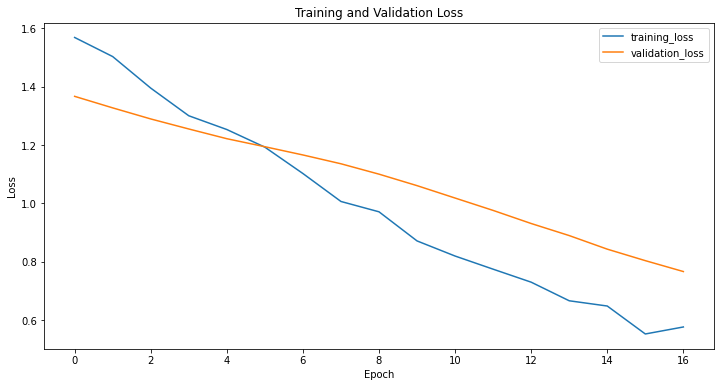

In [29]:
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

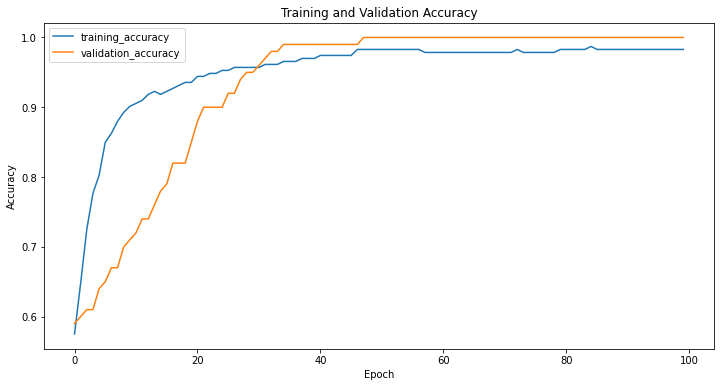

In [91]:
plt.plot(history.history['acc'], label='training_accuracy')
plt.plot(history.history['val_acc'], label='validation_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [92]:
# Evaluate the model
model.evaluate(X_t, y, verbose=0)

[0.05212625116109848, 0.9879879951477051]

In [93]:
# Look at the first 10 predictions
model.predict(X_t)[:10]

array([[9.8906660e-01, 9.7355973e-03, 1.1977496e-03],
       [9.6862298e-01, 2.6667371e-02, 4.7096717e-03],
       [9.2736161e-01, 6.8503276e-02, 4.1350815e-03],
       [9.9918324e-01, 6.3772989e-04, 1.7908259e-04],
       [9.9742162e-01, 2.3412388e-03, 2.3704160e-04],
       [9.7865385e-01, 1.8970286e-02, 2.3758628e-03],
       [9.9735093e-01, 1.2974326e-03, 1.3516045e-03],
       [7.0604444e-01, 2.8675923e-01, 7.1963319e-03],
       [9.9936980e-01, 5.3870399e-04, 9.1539805e-05],
       [9.9993336e-01, 3.0984877e-05, 3.5648143e-05]], dtype=float32)

In [95]:
 print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


In [78]:
keys = history.history.keys()

In [79]:
for key in keys:
    print (key)

loss
acc
val_loss
val_acc


<b> WEIGHTS </b>

In [85]:
model.get_weights()

[array([[-0.2021342 , -0.52398956, -0.39456084, -0.03405682,  0.88415927,
         -0.14573385, -0.35100287, -0.12934543,  0.7743712 , -0.2769007 ],
        [-0.1795314 ,  0.28073975,  0.12213817, -0.42209756,  0.2780948 ,
          0.33031613,  0.38943765,  0.10365221,  0.80225134, -0.5053686 ],
        [-0.23064572,  0.8197238 ,  0.41905284, -0.08424684, -0.19763748,
          0.7226037 , -0.07232069,  0.08506066, -0.17006712,  0.29559505],
        [ 0.60055745,  0.46431428, -0.64535975, -0.4719543 , -0.09545835,
          0.1262844 , -0.04551539, -0.12319717,  0.7037154 ,  0.21726388],
        [-0.27170444, -0.81607866, -0.07898765,  0.23190685,  0.5298667 ,
          0.8688656 ,  0.3009411 ,  0.40475565, -0.352946  , -0.0640467 ],
        [ 0.3498691 ,  0.42720047,  0.05672726,  0.03536846, -0.4524389 ,
          0.16529377, -0.60469955, -0.7585782 ,  0.6487256 ,  0.00132135],
        [-0.642278  , -0.05845499,  0.15685424,  0.38728297,  0.40904832,
         -0.02674877,  0.1730233

In [81]:
# Inspect the weights of the Neural Network
model.get_weights()[0] #input weights

array([[-0.2021342 , -0.52398956, -0.39456084, -0.03405682,  0.88415927,
        -0.14573385, -0.35100287, -0.12934543,  0.7743712 , -0.2769007 ],
       [-0.1795314 ,  0.28073975,  0.12213817, -0.42209756,  0.2780948 ,
         0.33031613,  0.38943765,  0.10365221,  0.80225134, -0.5053686 ],
       [-0.23064572,  0.8197238 ,  0.41905284, -0.08424684, -0.19763748,
         0.7226037 , -0.07232069,  0.08506066, -0.17006712,  0.29559505],
       [ 0.60055745,  0.46431428, -0.64535975, -0.4719543 , -0.09545835,
         0.1262844 , -0.04551539, -0.12319717,  0.7037154 ,  0.21726388],
       [-0.27170444, -0.81607866, -0.07898765,  0.23190685,  0.5298667 ,
         0.8688656 ,  0.3009411 ,  0.40475565, -0.352946  , -0.0640467 ],
       [ 0.3498691 ,  0.42720047,  0.05672726,  0.03536846, -0.4524389 ,
         0.16529377, -0.60469955, -0.7585782 ,  0.6487256 ,  0.00132135],
       [-0.642278  , -0.05845499,  0.15685424,  0.38728297,  0.40904832,
        -0.02674877,  0.17302333,  0.573876  

In [82]:
model.get_weights()[1] #input weights

array([ 0.20176019,  0.24208458, -0.13728085, -0.14883731,  0.3722174 ,
        0.311629  ,  0.0914636 ,  0.16857322,  0.27169004, -0.06238016],
      dtype=float32)

In [83]:
model.get_weights() # output weights

[array([[-0.2021342 , -0.52398956, -0.39456084, -0.03405682,  0.88415927,
         -0.14573385, -0.35100287, -0.12934543,  0.7743712 , -0.2769007 ],
        [-0.1795314 ,  0.28073975,  0.12213817, -0.42209756,  0.2780948 ,
          0.33031613,  0.38943765,  0.10365221,  0.80225134, -0.5053686 ],
        [-0.23064572,  0.8197238 ,  0.41905284, -0.08424684, -0.19763748,
          0.7226037 , -0.07232069,  0.08506066, -0.17006712,  0.29559505],
        [ 0.60055745,  0.46431428, -0.64535975, -0.4719543 , -0.09545835,
          0.1262844 , -0.04551539, -0.12319717,  0.7037154 ,  0.21726388],
        [-0.27170444, -0.81607866, -0.07898765,  0.23190685,  0.5298667 ,
          0.8688656 ,  0.3009411 ,  0.40475565, -0.352946  , -0.0640467 ],
        [ 0.3498691 ,  0.42720047,  0.05672726,  0.03536846, -0.4524389 ,
          0.16529377, -0.60469955, -0.7585782 ,  0.6487256 ,  0.00132135],
        [-0.642278  , -0.05845499,  0.15685424,  0.38728297,  0.40904832,
         -0.02674877,  0.1730233

In [84]:
model.get_weights()[3] # output bias

array([ 0.04626906,  0.12644413, -0.2362276 ], dtype=float32)